### Movie review binary classification
##### File reading and pre-processing dataset

In [9]:
# Loading necessary libraries
from sklearn.datasets import load_svmlight_files
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

In [10]:
## Reading data files for given train and test datasets
tr = "labeledBow2.feat" # train
ts = "labeledBow.feat" # test

# Splitting the file into feature and label vectors for train and test datasets
X_train, y_train, X_test, y_test = load_svmlight_files((tr, ts)) 

In [11]:
# Data exploration
print(str(X_train.shape)) 
print(type(X_train))

(25000, 89527)
<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
## Pre-processing data:
# Perform TF-IDF normalization on the feature vectors
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train)
X_test_tfidf = transformer.fit_transform(X_test)


In [13]:
## Turn target labels into binary class

y_train = [1 if rating > 5 else 0 for rating in y_train] 
y_test = [1 if rating > 5 else 0 for rating in y_test] 
# Rating considered Positive if target value = 1 
# Rating considered Negative if target value = 0 

In [16]:
print(X_train_tfidf)

  (0, 47304)	0.14472180168960277
  (0, 24551)	0.13249386453918274
  (0, 22409)	0.5493989055870607
  (0, 20604)	0.12886697348034268
  (0, 14239)	0.11886369062535644
  (0, 10480)	0.11248729882921026
  (0, 8567)	0.10846499436261635
  (0, 8319)	0.10846499436261635
  (0, 5812)	0.10101512003194743
  (0, 5731)	0.10033318120837427
  (0, 5726)	0.10222858122514818
  (0, 5715)	0.10078420812066262
  (0, 5138)	0.40045138334361885
  (0, 4938)	0.09751812801903044
  (0, 3647)	0.09172760468619126
  (0, 3520)	0.09124650391760698
  (0, 2938)	0.0878849086854847
  (0, 2934)	0.09274077054306715
  (0, 2379)	0.08492937991140254
  (0, 2285)	0.08361650372184952
  (0, 2243)	0.0829356375272536
  (0, 2096)	0.08234916776121083
  (0, 1941)	0.08148176676756014
  (0, 1940)	0.0834088499728388
  (0, 1477)	0.15861749293682706
  :	:
  (24999, 42)	0.04300922568029917
  (24999, 41)	0.043468250183661614
  (24999, 37)	0.04277552966978021
  (24999, 35)	0.08238041266060232
  (24999, 33)	0.08744948262425284
  (24999, 31)	0.03993

#### MODEL 1: Linear SVM

In [6]:
## Model WITHOUT regularization of parameter C

svm_raw= LinearSVC(max_iter = 100)

svm_raw.fit(X_train_tfidf, y_train)

print("Test accuracy: ", svm_raw.score(X_test_tfidf, y_test)*100, "%")
print("Train accuracy: ", svm_raw.score(X_train_tfidf, y_train)*100, "%")

Test accuracy:  87.932 %
Train accuracy:  99.084 %


The above task was conducted multiple time on varying values of `max_iter`. The accuracy results without regularizing C yielded very high training accuracy in contract to testing accuracy with is low around 87%. This indicates that regularization is needed in order to find less biased training model.

In [6]:
# Fitting mutiple C values to check model acccuracies

warnings.filterwarnings('ignore')

c_parameter_list = 2**np.array(range(-4,5), dtype='float') # List of C values to be tested
tr_accuracy_list = []     # empty list of training accuracies
ts_accuracy_list = []     # empty list of testing accuracies

# Train and test Linear SVM for each C value in c_parameter_list:
for c in c_parameter_list:
    # train LinearSVM with first C value in C parameter list
    model_lSVC= LinearSVC(C=c, max_iter = 100)
    model_lSVC.fit(X_train_tfidf, y_train)
    # calculate training and testing accuracies with given c value
    # and add them to the corresponding lists
    tr_accuracy_list.append(model_lSVC.score(X_train_tfidf, y_train)*100)
    ts_accuracy_list.append(model_lSVC.score(X_test_tfidf, y_test)*100)

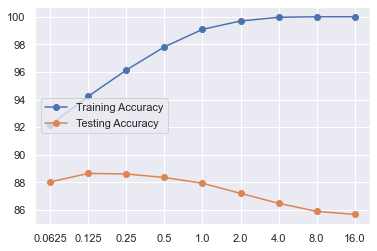

In [7]:
# Plot for accuracies of train, test set for differnt C parameter values 
import matplotlib.pyplot as plt
sns.set()

# C values are in log-scale, i.e. -1 for 0.5, 0 for 1, i for 2**i
plt.plot(np.log2(c_parameter_list), tr_accuracy_list, 'o-', label='Training Accuracy')

# plot the testing accuracy against C values
plt.plot(np.log2(c_parameter_list), ts_accuracy_list, 'o-', label='Testing Accuracy')

# change some plot parameters and display result
plt.xticks(np.log2(c_parameter_list), [str(x) for x in c_parameter_list])
plt.legend(loc='center left')
plt.show()

The plot indicates that with increase in value of parameter C, the training dataset increases its accuracy to 100% with corresponding decrease in accuracy of testing set. This shows that with high values of C, the training set gets susceptible to outliers which is leading to overfitting.

In [14]:
## Cross-Validation - finding best parameter
from sklearn import model_selection
warnings.filterwarnings('ignore')

c_parameter_list = 2**np.array(range(-4,5), dtype='float') # List of C values to be tested
cvscores_lSVC = [] # list of cross validation scores

for c in c_parameter_list:
    # train LinearSVM with first C value in C parameter list
    model_lSVC = LinearSVC(C=c, max_iter = 100)
    # K-fold crossvalidation is applied using 10 folds
    scores = model_selection.cross_val_score(model_lSVC, X_train_tfidf, y_train, cv=10)
    cvscores_lSVC.append(scores.mean()*100)

# Find best value of C by choosing the best mean score    
bestscore, bestC = max([(val, c_parameter_list[idx]) for (idx, val) in enumerate(cvscores_lSVC)])
print('Best Cross Validation accuracy =', bestscore, 'achieved at C =', bestC)

# Retrain on whole training set using best C value obtained from Cross validation

model_lSVC = LinearSVC(C=bestC)
model_lSVC.fit(X_train_tfidf, y_train)

# fitting the best model on test set
start = time.time()
accu = model_lSVC.score(X_test_tfidf, y_test)*100
end = time.time()
# Print time taken to retrain model usign best parameters
print("Time required to train =", end - start, "seconds")
print('Test accuracy =', accu, 'achieved at C =', bestC)

Best Cross Validation accuracy = 86.844 achieved at C = 0.125
Time required to train = 0.015300750732421875 seconds
Test accuracy = 88.644 achieved at C = 0.125


Now, the above trained model will be used to predict target values on feature test dataset.

In [10]:
## PREDICTION:

# Predicting using best model
test_predictions = model_lSVC.predict(X_test_tfidf)

# Create dataframe to store prediction results
results_lSVC = pd.DataFrame({
    'Review index': range(len(test_predictions)),
    'Predicted': test_predictions,
    'True': y_test
})

# Mapping target labels to their corresponding numerical value
results_lSVC['Predicted'] = results_lSVC['Predicted'].map({1: 'Positive', 0: 'Negative'})
results_lSVC['True'] = results_lSVC['True'].map({1: 'Positive', 0: 'Negative'})

# Print prediction results
df.to_csv("results_lSVC.csv", index=False)
print(results_lSVC.to_string(index=False))


## TEST ERROR:

# Calculate test error
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# Calculate the test error
test_error = 1 - accuracy_score(y_test, test_predictions)

# Display the test error 
print("Test Error: {:.4f}".format(test_error))

# Calculate precision
precision = precision_score(y_test, test_predictions)

# Calculate recall
recall = recall_score(y_test, test_predictions)

# Calculate F1 score
f1 = f1_score(y_test, test_predictions)

# Display the metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


 Review index Predicted     True
            0  Positive Positive
            1  Positive Positive
            2  Positive Positive
            3  Negative Positive
            4  Positive Positive
            5  Positive Positive
            6  Positive Positive
            7  Positive Positive
            8  Negative Positive
            9  Positive Positive
           10  Positive Positive
           11  Negative Positive
           12  Positive Positive
           13  Positive Positive
           14  Positive Positive
           15  Positive Positive
           16  Positive Positive
           17  Positive Positive
           18  Positive Positive
           19  Positive Positive
           20  Positive Positive
           21  Positive Positive
           22  Positive Positive
           23  Positive Positive
           24  Positive Positive
           25  Positive Positive
           26  Positive Positive
           27  Positive Positive
           28  Positive Positive
          

Predicted model shows low testing error and high precision.

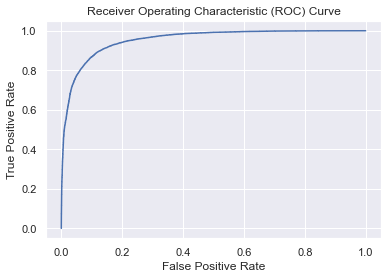

Area Under Curve (AUC): 0.9538497152000001


In [12]:
## AUC area:

from sklearn.metrics import roc_curve, roc_auc_score

# Get decision scores for the Positive class (1)
decision_scores = model_lSVC.decision_function(X_test_tfidf)

# Convert decision scores into probabilities
probabilities = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Calculate the AUC
auc = roc_auc_score(y_test, probabilities)
print('Area Under Curve (AUC):', auc)


#### MODEL 2: Random Forest 

For this model, the value of N estimate is set as 100 since after trying and testing on different ranges of N, it is observed that any higher values of N doesnt have any drastic affect on the model's performance. 
Next, cross validation is performed and the model is checked on differnt values of `max_depth` as follows.

In [20]:
## Cross validation on RandomForest

max_depth = [1, 5, 10, 15, 20, 25, 30] # list of depths to be tested

cvscores_forest = [] # list of cross validation scores for different depths

for depth in max_depth:
    # train Random Forest with first depth value from the depth list
    model_forest = RandomForestClassifier(n_estimators=100, max_depth=depth)
    scores_forest = cross_val_score(model_forest, X_train_tfidf, y_train, cv=5)
    cvscores_forest.append(scores_forest.mean()*100)

# Find best depth by choosing maximum mean depth value
bestscore_forest,best_depth = max([(val, max_depth[idx]) for (idx, val) in enumerate(cvscores_forest)])
print("Best CV accuracy =", bestscore_forest, " % achcieved at max_depth:", best_depth)

start = time.time()
# Retrain model using best depth
model_forest = RandomForestClassifier(n_estimators=100, max_depth=best_depth)
model_forest.fit(X_train_tfidf, y_train)

end = time.time()

# Print time taken to retrain model usign best parameters
print("Time required to train =", end - start, "seconds")

# Fitting the best model on test set
ts_accuracy_forest = model_forest.score(X_test_tfidf, y_test)*100
print("Testing accuracy =", ts_accuracy_forest, "%")

Best CV accuracy = 82.964  % achcieved at max_depth: 30
Time required to train = 32.883654832839966 seconds
Testing accuracy = 83.25200000000001 %


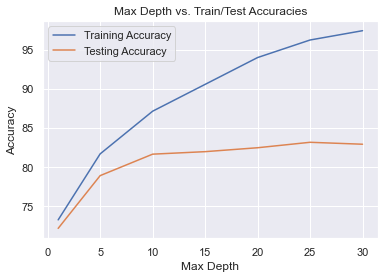

In [18]:
# Plotting accuracies of train and test set with respect to the tree depths

import matplotlib.pyplot as plt
import numpy as np

max_depth = [1, 5, 10, 15, 20, 25, 30] # list of tree depths

train_acc = [] # list of training accuracy
test_acc = [] # list of testing accuracies

for depth in max_depth:
    # train model on first depth value from the list of depth values defined above
    model = RandomForestClassifier(n_estimators=100, max_depth=depth)
    model.fit(X_train_tfidf, y_train)
    # append the model accuracies to the corresponding lists
    train_acc.append(model.score(X_train_tfidf, y_train) * 100)
    test_acc.append(model.score(X_test_tfidf, y_test) * 100)

# Creating the plot     
plt.plot(max_depth, train_acc, label='Training Accuracy')
plt.plot(max_depth, test_acc, label='Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Max Depth vs. Train/Test Accuracies')
plt.legend()
plt.show()


The plot above shows that keeping N estimate constant at 100, the accuracies of the training and validation sets show an increase starting from depth = 1. As the depth increases, the variance in the accuracies for both the sets is limited. The model obtains the best value at depth = 30 but if the depth is further increased, it is probable that the model will be a highly snug-fit to the training set. So, the prediction is done accepting the cross-validation results as below.

In [19]:
## PREDICTION:

# Predicting using best model
test_predictions = model_forest.predict(X_test_tfidf)

# Create dataframe to store prediction results
results_forest = pd.DataFrame({
    'Review index': range(len(test_predictions)),
    'Predicted': test_predictions,
    'True': y_test
})

# Mapping target labels to their corresponding numerical value
results_forest['Predicted'] = results_forest['Predicted'].map({1: 'Positive', 0: 'Negative'})
results_forest['True'] = results_forest['True'].map({1: 'Positive', 0: 'Negative'})

# Print prediction results
pd.Dataframe(results_forest.to_csv("forest_pred.csv"))
print(results_forest.to_string(index=False))

## TEST ERROR:

# Calculate test error
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# Calculate the test error
test_error = 1 - accuracy_score(y_test, test_predictions)

# Display the test error 
print("Test Error: {:.4f}".format(test_error))

# Calculate precision
precision = precision_score(y_test, test_predictions)

# Calculate recall
recall = recall_score(y_test, test_predictions)

# Calculate F1 score
f1 = f1_score(y_test, test_predictions)

# Display the metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

NameError: name 'model_forest' is not defined

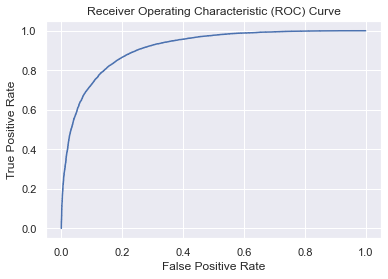

Area Under Curve (AUC) for Random Forest: 0.9132403264


In [20]:
## AUC area:

from sklearn.metrics import roc_curve, roc_auc_score

# Get decision scores for the Positive class (1)
decision_scores = model_forest.predict_proba(X_test_tfidf)[:,1]

# Convert decision scores into probabilities
#probabilities = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Calculate the AUC
auc = roc_auc_score(y_test, decision_scores)
print('Area Under Curve (AUC) for Random Forest:', auc)


#### Conclusion:
After analysing both the models, it can be observed that Linear SVM and Random Forest gives similar prediction models. Foremostly, this can be observed from how the models perform on the training sets. Linear SVM and Random Forest give approximately 86.9% and 83.2% accuracies respectively on the training data while 88.6% and 83.4% accuracies on testing. The test errors are low and the ROC area is very close to 1 which show that the models are pretty accurate. 
However, the Linear SVM is better than Random Forest model when it comes to performance and speed trade-off. Random Forest model takes thirty times more time to yield the same results as Linear SVM in this instance. Hence, Linear SVM model is more efficient on this analysis. 